In [1]:
import pandas as pd
import xml.etree.ElementTree as etree
import os
from os import listdir
from os.path import isfile, join

# Configuration Variables
top = 25 # Top X projects to be analyzed

dir = os.path.join("results")



In [4]:
# Reading the projects xml file
projects_ranking_file = os.path.join('jmh-projects-bigquery-fh-201702 - jmh-projects-gh.csv')
projects_ranking = pd.read_csv(projects_ranking_file, sep=',')

# Normalize the columns
projects_ranking['name'] = projects_ranking['project'].apply(lambda x: x.split('/')[0])
projects_ranking['xml'] = projects_ranking['project'].apply(lambda x: x.split('/')[1] + '.xml')

projects_ranking.head(3)

,project,forked,watchers,stars,forks,subscribers,name,xml
0,ReactiveX/RxJava,False,23558,23558,4143,1754,ReactiveX,RxJava.xml
1,Netflix/feign,False,1716,1716,335,276,Netflix,feign.xml
2,netty/netty,False,9746,9746,4775,1243,netty,netty.xml


In [5]:
# Remove projects that could not be analyzed
projects_to_remove = ['jgrapht/jgrapht', 'lemire/RoaringBitmap', 'RoaringBitmap/RoaringBitmap', 
                      'requery/requery', 'Netflix/feign', 'crate/crate', 'real-logic/simple-binary-encoding', 
                      'jbachorik/btrace', 'promeG/TinyPinyin', 'pcollections/pcollections', 'ktoso/sbt-jmh', 
                      'junkdog/artemis-odb', 'fakemongo/fongo', 'graalvm/truffle', 'graalvm/graal-core']

projects_ranking = projects_ranking[~projects_ranking['project'].isin(projects_to_remove)] # jgrapht

top_projects = projects_ranking.sort_values(by=['watchers', 'stars', 'forks'], ascending=False)[:top]
top_projects

,project,forked,watchers,stars,forks,subscribers,name,xml
0,ReactiveX/RxJava,False,23558,23558,4143,1754,ReactiveX,RxJava.xml
2,netty/netty,False,9746,9746,4775,1243,netty,netty.xml
3,openzipkin/zipkin,False,5627,5627,851,507,openzipkin,zipkin.xml
4,druid-io/druid,False,4743,4743,1132,457,druid-io,druid.xml
5,square/okio,False,3703,3703,601,220,square,okio.xml
6,grpc/grpc-java,False,2631,2631,821,380,grpc,grpc-java.xml
7,ben-manes/caffeine,False,2414,2414,192,176,ben-manes,caffeine.xml
8,h2oai/h2o-3,False,1943,1943,836,283,h2oai,h2o-3.xml
10,goldmansachs/gs-collections,False,1652,1652,247,204,goldmansachs,gs-collections.xml
12,raphw/byte-buddy,False,1495,1495,156,97,raphw,byte-buddy.xml


In [6]:
import xml.etree.ElementTree as ET
from collections import Counter
    
def analyzeBugCollections(df):
    
    tree = ET.parse(os.path.join(dir, df['xml']))
    root = tree.getroot()
    
    all_bugs = root.findall('BugInstance')
    
    benchmarks = set()
    bugs_per_class = [] 
    for b in all_bugs:
        bug_type = b.get('type')
        clazz = b.find('Class')
        if(clazz):
            clazzname = clazz.get('classname')  # Guaranteed to be unique ?
            if bug_type == 'JMH_BENCHMARK_METHOD_FOUND': # Take those bugs out of the analysis
                benchmarks.add(clazzname)
            else:
                bugs_per_class.append(clazzname)
                
    bugs = Counter(bugs_per_class)
    
    df['Bugs per Class'] = bugs
    df['Classes with Benchmarks'] = benchmarks
    return df
        
    
    
top_projects = top_projects.apply(analyzeBugCollections, axis=1)
#top_projects[['name','Bugs per Class','Classes with Benchmarks']].loc[0].to_csv('ReactiveX')   
top_projects

,project,forked,watchers,stars,forks,subscribers,name,xml,Bugs per Class,Classes with Benchmarks
0,ReactiveX/RxJava,False,23558,23558,4143,1754,ReactiveX,RxJava.xml,"{'io.reactivex.OperatorFlatMapPerf': 1, 'io.re...","{io.reactivex.BlockingGetPerf, io.reactivex.St..."
2,netty/netty,False,9746,9746,4775,1243,netty,netty.xml,{'io.netty.buffer.AbstractReferenceCountedByte...,{io.netty.microbench.buffer.ByteBufUtilBenchma...
3,openzipkin/zipkin,False,5627,5627,851,507,openzipkin,zipkin.xml,"{'zipkin.benchmarks.CodecBenchmarks': 24, 'zip...","{zipkin.benchmarks.UtilBenchmarks, zipkin.benc..."
4,druid-io/druid,False,4743,4743,1132,457,druid-io,druid.xml,{'io.druid.benchmark.BitmapIterationBenchmark'...,"{io.druid.benchmark.FilterPartitionBenchmark, ..."
5,square/okio,False,3703,3703,601,220,square,okio.xml,{'com.squareup.okio.benchmarks.BufferPerforman...,{com.squareup.okio.benchmarks.IndexOfElementBe...
6,grpc/grpc-java,False,2631,2631,821,380,grpc,grpc-java.xml,"{'io.grpc.AttachDetachBenchmark': 2, 'io.grpc....","{io.grpc.AttachDetachBenchmark, io.grpc.intern..."
7,ben-manes/caffeine,False,2414,2414,192,176,ben-manes,caffeine.xml,{'com.github.benmanes.caffeine.DelegationBench...,{com.github.benmanes.caffeine.SingleConsumerQu...
8,h2oai/h2o-3,False,1943,1943,836,283,h2oai,h2o-3.xml,"{'hex.pca.PCAImputeMissingScoringBench': 2, 'h...","{hex.pca.PCAWideDataSetsScoringBench, water.mo..."
10,goldmansachs/gs-collections,False,1652,1652,247,204,goldmansachs,gs-collections.xml,{'com.gs.collections.impl.jmh.AggregateByTest'...,"{com.gs.collections.impl.jmh.AnySatisfyTest, c..."
12,raphw/byte-buddy,False,1495,1495,156,97,raphw,byte-buddy.xml,{'net.bytebuddy.benchmark.ClassByExtensionBenc...,{net.bytebuddy.benchmark.ClassByImplementation...


In [7]:
def isEntityBuggy(counter, t):
    buggy = []
    for p in counter:
        buggy.append(counter[p] > t)
    return buggy
   
def amountOfBuggyEntities(s, t = 0):
    return isEntityBuggy(s, t).count(True)


# Analysis Bugs per Package - do all benchmark packages have bugs?
#top_projects['# Class has > 0 bugs'] = top_projects['Bugs per Class'].apply(amountOfBuggyEntities)
top_projects['Class has > 0 bugs'] = top_projects['Bugs per Class'].apply(amountOfBuggyEntities)
top_projects['Class has > 5 bugs'] = top_projects['Bugs per Class'].apply(amountOfBuggyEntities, args=(5,))
top_projects['Class has > 10 bugs'] = top_projects['Bugs per Class'].apply(amountOfBuggyEntities, args=(10,))

top_projects

,project,forked,watchers,stars,forks,subscribers,name,xml,Bugs per Class,Classes with Benchmarks,Class has > 0 bugs,Class has > 5 bugs,Class has > 10 bugs
0,ReactiveX/RxJava,False,23558,23558,4143,1754,ReactiveX,RxJava.xml,"{'io.reactivex.OperatorFlatMapPerf': 1, 'io.re...","{io.reactivex.BlockingGetPerf, io.reactivex.St...",25,24,0
2,netty/netty,False,9746,9746,4775,1243,netty,netty.xml,{'io.netty.buffer.AbstractReferenceCountedByte...,{io.netty.microbench.buffer.ByteBufUtilBenchma...,82,55,5
3,openzipkin/zipkin,False,5627,5627,851,507,openzipkin,zipkin.xml,"{'zipkin.benchmarks.CodecBenchmarks': 24, 'zip...","{zipkin.benchmarks.UtilBenchmarks, zipkin.benc...",8,7,2
4,druid-io/druid,False,4743,4743,1132,457,druid-io,druid.xml,{'io.druid.benchmark.BitmapIterationBenchmark'...,"{io.druid.benchmark.FilterPartitionBenchmark, ...",72,55,11
5,square/okio,False,3703,3703,601,220,square,okio.xml,{'com.squareup.okio.benchmarks.BufferPerforman...,{com.squareup.okio.benchmarks.IndexOfElementBe...,10,5,0
6,grpc/grpc-java,False,2631,2631,821,380,grpc,grpc-java.xml,"{'io.grpc.AttachDetachBenchmark': 2, 'io.grpc....","{io.grpc.AttachDetachBenchmark, io.grpc.intern...",9,4,0
7,ben-manes/caffeine,False,2414,2414,192,176,ben-manes,caffeine.xml,{'com.github.benmanes.caffeine.DelegationBench...,{com.github.benmanes.caffeine.SingleConsumerQu...,30,21,0
8,h2oai/h2o-3,False,1943,1943,836,283,h2oai,h2o-3.xml,"{'hex.pca.PCAImputeMissingScoringBench': 2, 'h...","{hex.pca.PCAWideDataSetsScoringBench, water.mo...",15,9,0
10,goldmansachs/gs-collections,False,1652,1652,247,204,goldmansachs,gs-collections.xml,{'com.gs.collections.impl.jmh.AggregateByTest'...,"{com.gs.collections.impl.jmh.AnySatisfyTest, c...",115,73,6
12,raphw/byte-buddy,False,1495,1495,156,97,raphw,byte-buddy.xml,{'net.bytebuddy.benchmark.ClassByExtensionBenc...,{net.bytebuddy.benchmark.ClassByImplementation...,8,6,0


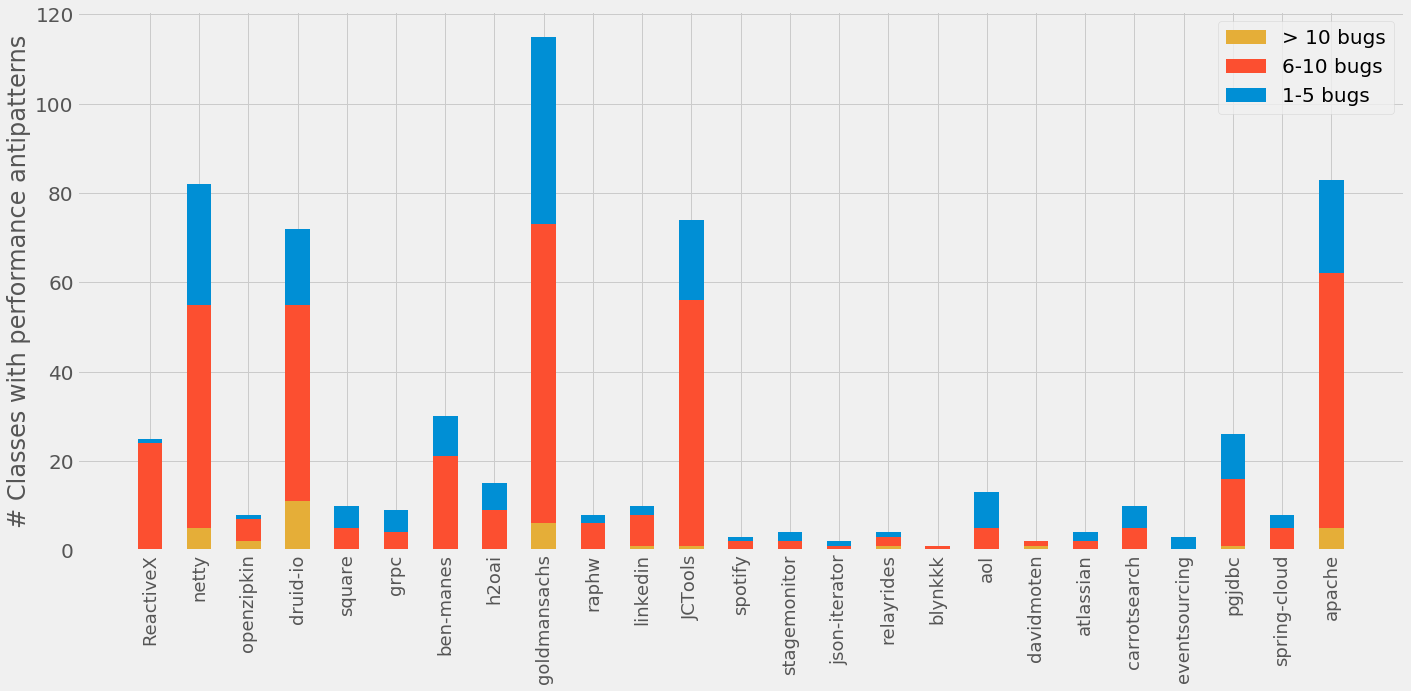

In [14]:
# Plot the class analysis
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import numpy as np

style.use('fivethirtyeight')

#plt.rcParams["font.family"] = "Times New Roman"

_0means = top_projects['Class has > 0 bugs']
_5means = top_projects['Class has > 5 bugs']
_10means = top_projects['Class has > 10 bugs']


ind = np.arange(len(top_projects))    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

# plt.figure(figsize=(20,10))
# plt.rc('font', size=20)   

p3 = plt.bar(ind, _0means, width )
p2 = plt.bar(ind, _5means, width )
p1 = plt.bar(ind, _10means, width)

plt.ylabel('# Classes with performance antipatterns')
#plt.title('Buggy classes per project')
plt.xticks(ind, top_projects['name'], fontsize=18, rotation=90)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0]), ('> 10 bugs', '6-10 bugs', '1-5 bugs'))
plt.tight_layout()

plt.savefig('buggyclasses-per-project.pdf')

plt.show()


In [9]:
buggy_classes_tb = pd.DataFrame()

buggy_classes_tb['Project']=top_projects.name

#buggy_classes_tb['No bugs'] = '?'
buggy_classes_tb['1-5 bugs'] = top_projects['Class has > 0 bugs'] - top_projects['Class has > 5 bugs']
buggy_classes_tb['6-10 bugs'] = top_projects['Class has > 5 bugs'] - top_projects['Class has > 10 bugs']
buggy_classes_tb['> 10 bugs'] = top_projects['Class has > 10 bugs']

buggy_classes_tb

,Project,1-5 bugs,6-10 bugs,> 10 bugs
0,ReactiveX,1,24,0
2,netty,27,50,5
3,openzipkin,1,5,2
4,druid-io,17,44,11
5,square,5,5,0
6,grpc,5,4,0
7,ben-manes,9,21,0
8,h2oai,6,9,0
10,goldmansachs,42,67,6
12,raphw,2,6,0


In [10]:
print(buggy_classes_tb.to_latex(index=False, bold_rows=True))

\begin{tabular}{lrrr}
\toprule
       Project &  1-5 bugs &  6-10 bugs &  > 10 bugs \\
\midrule
     ReactiveX &         1 &         24 &          0 \\
         netty &        27 &         50 &          5 \\
    openzipkin &         1 &          5 &          2 \\
      druid-io &        17 &         44 &         11 \\
        square &         5 &          5 &          0 \\
          grpc &         5 &          4 &          0 \\
     ben-manes &         9 &         21 &          0 \\
         h2oai &         6 &          9 &          0 \\
  goldmansachs &        42 &         67 &          6 \\
         raphw &         2 &          6 &          0 \\
      linkedin &         2 &          7 &          1 \\
       JCTools &        18 &         55 &          1 \\
       spotify &         1 &          2 &          0 \\
  stagemonitor &         2 &          2 &          0 \\
 json-iterator &         1 &          1 &          0 \\
    relayrides &         1 &          2 &          1 \\
       b

In [11]:
from collections import Counter

# This is currently not useful 
def analyzeBugCollection(df):
    
    tree = ET.parse(os.path.join(dir, df['xml']))
    root = tree.getroot()
    #collection = root.get('BugCollection')
    
    all_bugs = root.findall('BugInstance')
    
    benchmarks = set()
    methods_reported = [] 
    for b in all_bugs:
        bug_type = b.get('type')
        method = b.find('Method')
        if(method):
            signature = method.get('classname') + "_" + method.get('name') # Guaranteed to be unique per method
            # add the benchmark (is this useful?) - we need to filter out this anyway
            if bug_type == 'JMH_BENCHMARK_METHOD_FOUND':
                benchmarks.add(signature)
            else:
                methods_reported.append(signature)

    bugs_per_method = Counter(methods_reported)
    df['benchmarks'] = benchmarks    
    df['bugs_per_method'] = bugs_per_method
    return df

#test_projects = top_projects[:2]
#test_projects = test_projects.apply(analyzeBugCollection, axis=1)
#test_projects

#top_projects = top_projects.apply(analyzeBugCollection, axis=1)
#top_projects.to_csv(os.path.join('top_projects_analysis.csv'), sep=';')